In [2]:
import tensorflow as tf
import numpy as np

In [3]:
from eikonal_pinn_solver import EikonalPINNSolver
from pinn_neural_net import PINN_NeuralNet

In [4]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

N_0 = 50
N_b = 50
N_r = 10000

# Specify boundaries
lb = tf.constant([0., -1.], dtype=DTYPE)
ub = tf.constant([1., 1.], dtype=DTYPE)

def Eikonal_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def Eikonal_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

In [5]:
tf.random.set_seed(0)

# Final time data
t_0 = tf.ones((N_0,1), dtype=DTYPE) * ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = Eikonal_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)
u_b = Eikonal_u_b(t_b, x_b)

# Collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0,X_b]
u_data = [u_0,u_b]

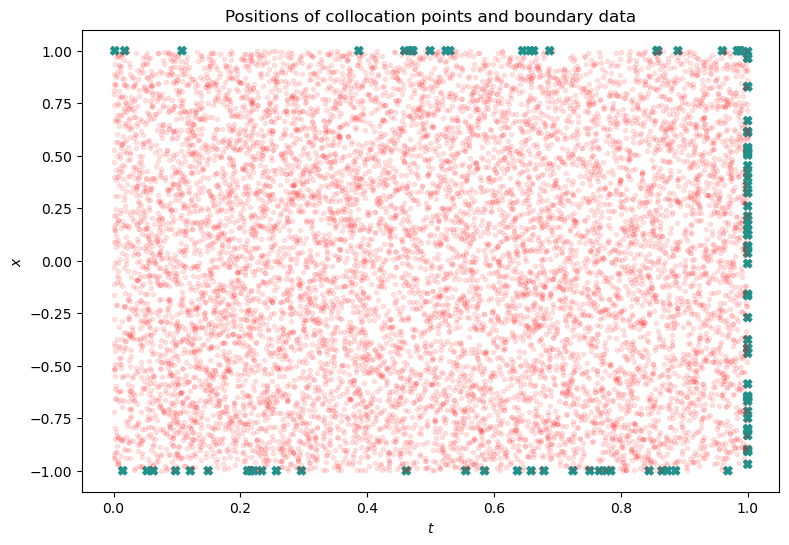

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [7]:
# Initialize model
model = PINN_NeuralNet(lb, ub, num_hidden_layers=2,
                       activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                       kernel_initializer='he_normal')
model.build(input_shape=(None,2))

# Initilize PINN solver
eikonalSolver = EikonalPINNSolver(model, X_r)

In [8]:
from time import time

# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time()
eikonalSolver.solve_with_TFoptimizer(optim, X_data, u_data, N=10001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 4.59581718e+01
It 00050: loss = 8.44158530e-02
It 00100: loss = 5.00384606e-02
It 00150: loss = 2.98081823e-02
It 00200: loss = 1.63681470e-02
It 00250: loss = 9.09537822e-03
It 00300: loss = 7.32776895e-03
It 00350: loss = 6.97098300e-03
It 00400: loss = 5.94768114e-03
It 00450: loss = 4.51994361e-03
It 00500: loss = 3.47585790e-03
It 00550: loss = 3.01111909e-03
It 00600: loss = 2.83030258e-03
It 00650: loss = 2.61980761e-03
It 00700: loss = 2.52761482e-03
It 00750: loss = 2.87330244e-03
It 00800: loss = 2.34805350e-03
It 00850: loss = 2.12511839e-03
It 00900: loss = 1.89319183e-03
It 00950: loss = 1.70578342e-03
It 01000: loss = 1.52245862e-03
It 01050: loss = 1.22055446e-03
It 01100: loss = 1.02562271e-03
It 01150: loss = 9.68844630e-04
It 01200: loss = 8.90751719e-04
It 01250: loss = 7.95081840e-04
It 01300: loss = 6.76869531e-04
It 01350: loss = 5.94673795e-04
It 01400: loss = 5.48967102e-04
It 01450: loss = 4.48561070e-04
It 01500: loss = 4.02869162e-04
It 01550

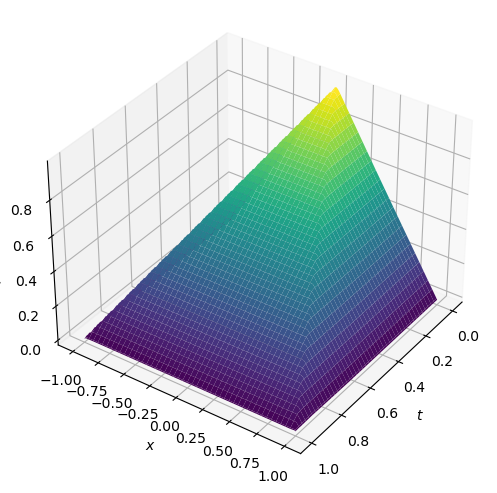

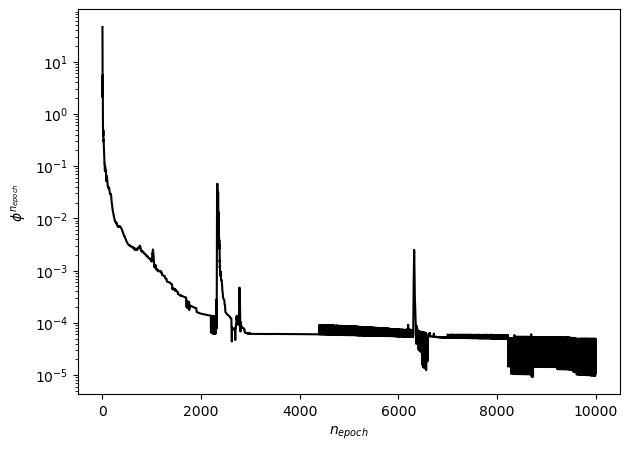

In [9]:
eikonalSolver.plot_solution();
#plt.savefig('Eikonal_Solution.pdf', bbox_inches='tight', dpi=300)
eikonalSolver.plot_loss_history();